In [1]:
# import libs
import tensorflow as tf

In [2]:
tf.__version__

'2.2.0'

In [3]:
!pip install -q imageio

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
# Init wandb
import wandb
from wandb.tensorflow import WandbHook
wandb.init(project="mnist-gan-test", sync_tensorboard=True)

W&B Run: https://app.wandb.ai/blueybloke/mnist-gan-test/runs/1dzk9tv9

In [6]:
# Prepare the data
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

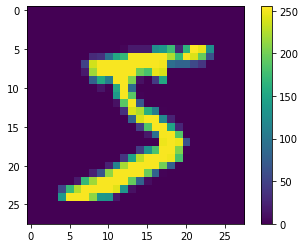

In [7]:
# Real quick plot the first bit of training data
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
# Shape training images to be consistent
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [9]:
# Declare some constants
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
# batch the data and shuffle it
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
print("Dataset ready and shuffled!")

Dataset ready and shuffled!


In [12]:
# Define the model for the generator
def make_generator_model():
    model = tf.keras.Sequential() # Create a linear stack of layers style model
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # Start with a Dense (classic) NN layer, with seed as input
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size, make sure the model so far is outputting the right shape

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    # model has been upsampled to the right shape, return it.
    return model

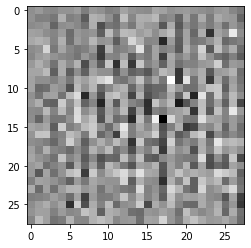

In [13]:
generator = make_generator_model() # Create the model

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False) # Pass some noise to the model, no training

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
# Define the model for the generator
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # Prevent overfitting of model

    model.add(layers.Conv2D(128, (5,5 ), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # Prevent overfitting of model

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model() # Make the discriminator model
decision = discriminator(generated_image)
print(decision) # The discriminator is still untrained at this point. Positive values means real negative means fake

tf.Tensor([[0.00319183]], shape=(1, 1), dtype=float32)


In [16]:
# This method returns a helper function to compute cross entropy loss.
# This loss function increases from 0 to 1 as the predicted probability diverges from the actual label.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
# This function grades the discriminator's output, generating a value of 0 to 1 rating the discriminator model.
# It does this by using the cross_entropy function to compare predictions on real images with an array of 1's
# and fake images with an array of 0's.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
# This function grades the generator's output based on how much it was able to fool the discriminator.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
checkpoint_dir = './training-checkpoints-mnist'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

# Define a single training step.
@tf.function
def train_step(images, currentepoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Make some noise 🎉

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      # Log the loss, real output and fake output
      wandb.log({'epoch': currentepoch, 'gen_loss': gen_loss, 'disc_loss': disc_loss, 'generated_images': generated_images, 'real_output': real_output, 'fake_output': fake_output})

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
# Define a method to train the models
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch, epoch)

        # Make a pretty GIF of the process # Define a method to train the models
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            latest_path = checkpoint.save(file_prefix=checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate the final gif when done
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)
    print("Training complete!")
    return latest_path

In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [25]:
# Train the model and save to W&B! 😁
model_path = train(train_dataset, EPOCHS)
wandb.save(model_path)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warnin

Failed to connect to W&B servers after 10 seconds.                    Letting user process proceed while attempting to reconnect.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: in user code:

    <ipython-input-22-4bece25c527c>:19 train_step  *
        wandb.log({'epoch': currentepoch, 'gen_loss': gen_loss, 'disc_loss': disc_loss, 'generated_images': generated_images, 'real_output': real_output, 'fake_output': fake_output})
    E:\anaconda3\envs\logo-GAN\lib\site-packages\wandb\__init__.py:767 log  *
        run.log(row, commit, step, sync, *args, **kwargs)
    E:\anaconda3\envs\logo-GAN\lib\site-packages\wandb\wandb_run.py:673 log  *
        self.history.add(row, *args, step=step, commit=commit, **kwargs)
    E:\anaconda3\envs\logo-GAN\lib\site-packages\wandb\history.py:139 add  *
        self._write()
    E:\anaconda3\envs\logo-GAN\lib\site-packages\wandb\history.py:245 _write  *
        self._file.write(util.json_dumps_safer_history(self.row))
    E:\anaconda3\envs\logo-GAN\lib\site-packages\wandb\util.py:488 json_dumps_safer_history  *
        return json.dumps(obj, cls=WandBHistoryJSONEncoder, **kwargs)
    E:\anaconda3\envs\logo-GAN\lib\json\__init__.py:238 dumps  *
        **kw).encode(obj)
    E:\anaconda3\envs\logo-GAN\lib\json\encoder.py:199 encode  *
        chunks = self.iterencode(o, _one_shot=True)
    E:\anaconda3\envs\logo-GAN\lib\json\encoder.py:257 iterencode  *
        return _iterencode(o, 0)

    ValueError: Circular reference detected


Error in callback <function _init_jupyter.<locals>.cleanup at 0x000002AFD263D048> (for post_run_cell):


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
# Make animated GIF using ImageIO and saved images
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)